![Авто](https://img2.goodfon.ru/wallpaper/nbig/4/4a/auto-cars-ac-cobra-cobra.jpg)

# Прогнозирование стоимости автомобиля по его характеристикам
Часть 3
__________________________________________________________________________________________________________________

**Этот ноутбук включает:**
> - заключительную предобработку собранных с внешнего сайта [auto.ru](https://auto.ru/)  данных;
> - обработку тестовых данных test.csv с целью стыковки их с train датасетом;
> - feature enginiring обработанного общего датасета train+test;
> - создание модели предсказания цен на автомобили и проверки предсказаний модели на соревновании сайта kaggle.com;

# Содержание

- [1. Библиотеки](#1.-Библиотеки)
- [2. Заключительная предобработка данных](#2.-Заключительная-предобработка-данных)
    * [2.1 Дообработка train dataset](#2.1-Дообработка-train-dataset)
    * [2.2 Приведение test dataset в соответствие с train dataset](#2.2-Приведение-test-dataset-в-соответствие-с-train-dataset)
- [3. Feature engineering](#3.-Feature-engineering)
- [4. Моделирование](#4.-Моделирование)
    * [4.1 Наивное моделирование](#4.1-Наивное-моделирование)
    * [4.2 Ранжирование дефолтных моделей](#4.2-Ранжирование-дефолтных-моделей)
    * [4.3 Поиск лучших гиперпараметров](#4.3-Поиск-лучших-гиперпараметров)
    * [4.4 Стекинг алгоритмов](#4.4-Стекинг-алгоритмов)
    * [4.5 Формирование файла Submission](#4.5-Формирование-файла-Submission)

# **1. Библиотеки**

In [1]:
#Загружаем необходимые нам библиотеки
#библиотеки для моделирования
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

#для разбиения признаков, выборок и сеток для поиска лучших гиперпараметров
from sklearn.model_selection import cross_val_score, train_test_split, KFold, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#для оценки качества классификации
#загрузим собственную метрику
from sklearn.metrics import make_scorer

#предобработка признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#библиотеки отбора признаков и оценки их значимости
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

from sklearn.base import clone

#общие библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import sys
from tqdm.notebook import tqdm
import json
import re
import itertools
%matplotlib inline

# 2. **Заключительная предобработка данных**

## `2.1 Дообработка train dataset`

In [3]:
# директория с файлами проекта
DIR = 'C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/module_5/'

# загружаем собранный датасет в датафрейм
train = pd.read_csv(DIR + 'data_auto_processed_FINAL_3.csv')

# загружаем тестовый датасет в датафрейм
test = pd.read_csv(DIR + 'test.csv')

# загружаем файл с форматом для подачи прогнозных значений на оценку
sample_submission = pd.read_csv(DIR + 'sample_submission.csv')

In [4]:
pd.set_option('display.max_columns', None) #установим режим для полного просмотра колонок датасетов

In [5]:
# устраним дубликаты и посмотрим на структуру данных
train.drop_duplicates(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80076 entries, 0 to 86361
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bodytype            80076 non-null  object 
 1   brand               80076 non-null  object 
 2   mileage             80076 non-null  int64  
 3   color               80076 non-null  object 
 4   complectation       80076 non-null  int64  
 5   tax                 80076 non-null  int64  
 6   transmission        80076 non-null  object 
 7   drive               80076 non-null  object 
 8   wheel               80076 non-null  object 
 9   owners              80076 non-null  int64  
 10  customs             80075 non-null  object 
 11  pts                 80076 non-null  object 
 12  year                80076 non-null  int64  
 13  price               80076 non-null  int64  
 14  model_name          80076 non-null  object 
 15  engineDisplacement  80076 non-null  float64
 16  engi

 ```
 Тестовый датасет был собран в октябре 2020 года, судя по парсинг времени,
 а к осени 2021 года цены на подержанные автомобили сильно выросли.
  
 Ниже приводится график динамики цен на подержанные автомобили.
 По причине роста цен, цены в собранном датасете необходимо скорректировать и привести к уровню осени 2020 года
  ```

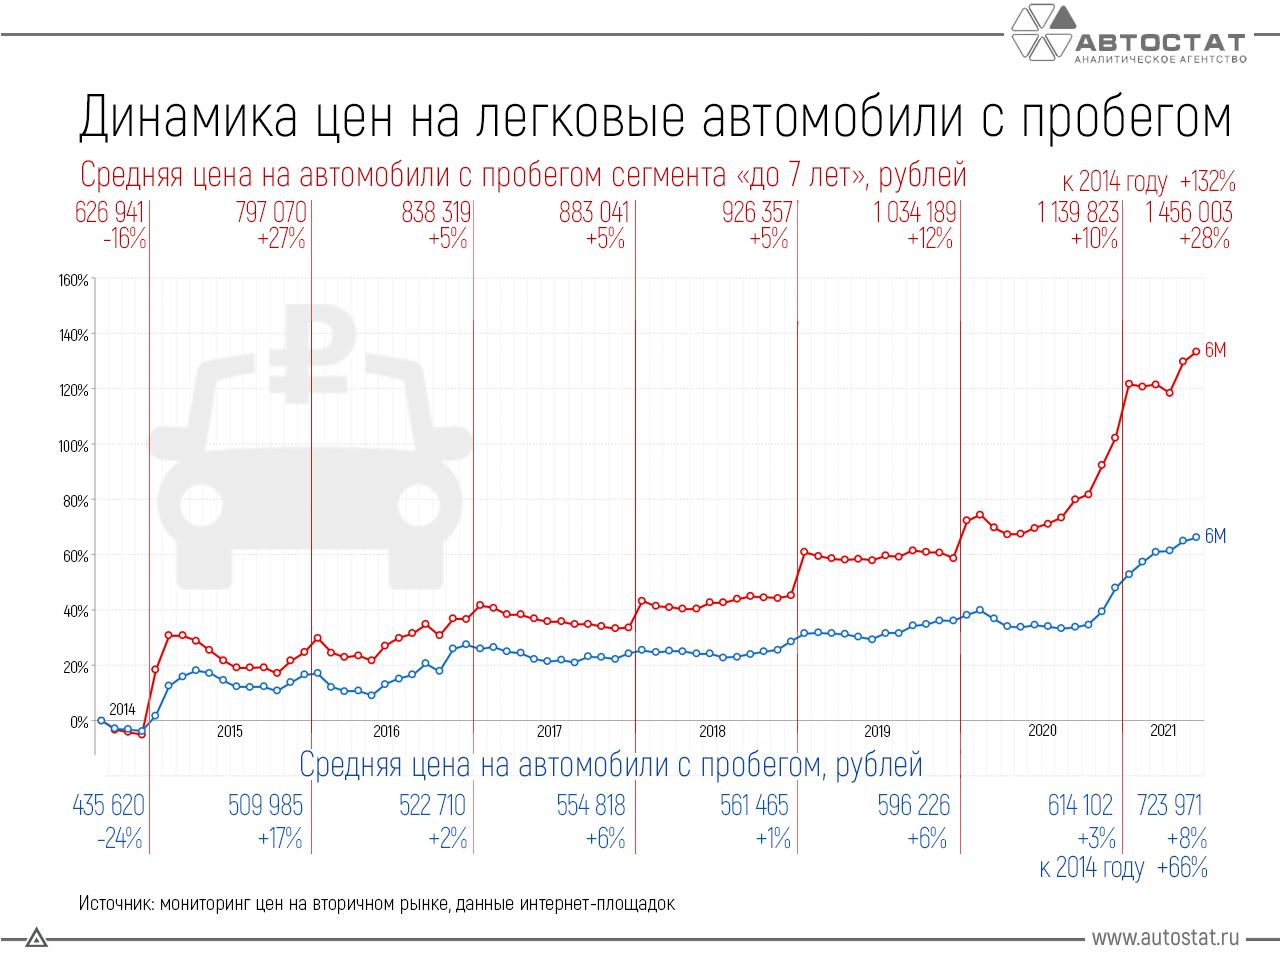

In [6]:
#сделаем функцию корректировки цен и применим ее к таргету
#наилучшие коэффициенты корректировки пришлось подбирать руками
def price_correction(year, price):
    if year >= 2014:
        return price/1.23
    else:
        return price/1.3
    
train['new_price'] = train[['year','price']].apply(lambda x: price_correction(x['year'], x['price']), axis=1)

In [7]:
# в собранных данных автомобили некоторых моделей не совпадают по написанию с данными в файле test.csv
# приведем их в соответствие
model_name_train = ['MERCEDES-BENZ','7','5','3','E-КЛАСС','C-КЛАСС',
                    'M-КЛАСС','S-КЛАСС','X-TRAIL','LAND','RAV4']
model_name_test = ['MERCEDES','7ER','5ER','3ER','E_KLASSE','C_KLASSE',
                   'M_KLASSE','S_KLASSE', 'X_TRAIL','LAND_CRUISER','RAV_4']

for i in range (11):
    train.replace(model_name_train[i], model_name_test[i], inplace=True)

train.sample(5)

,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,customs,pts,year,price,model_name,engineDisplacement,enginePower,fuelType,new_price
46233,седан,MERCEDES,241689,чёрный,6,16800,автоматическая,задний,Левый,1,Растаможен,Оригинал,2009,1270000,CLS,3.0,224,Дизель,9.769231e+05
81815,седан,TOYOTA,5150,чёрный,7,2700,вариатор,передний,Левый,2,ТаможняРастаможен,ПТСОригинал,2021,2577000,CAMRY,2.0,150,Бензин,2.095122e+06
11288,седан,INFINITI,171000,чёрный,0,49950,автоматическая,полный,Левый,1,Растаможен,Оригинал,2012,1149000,M,3.7,333,Бензин,8.838462e+05
4297,внедорожник 5 дв.,BMW,105000,серый,0,38700,автоматическая,полный,Левый,1,Растаможен,Оригинал,2011,1420000,X3,3.0,258,Бензин,1.092308e+06
31872,седан,VOLVO,158306,красный,0,2650,механическая,передний,Левый,1,Растаможен,Оригинал,1990,60000,460,1.7,106,Бензин,4.615385e+04


In [8]:
# в тестовом датасете всего 12 брендов автомобилей
# оставим в собранных данных train.csv только 12 брендов, чтобы структура датасетов была схожей
test_brands = list(test.brand.unique())
train_test = train.loc[train['brand'].isin(test_brands)]
train_test.brand.unique()

array(['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES',
       'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLVO', 'VOLKSWAGEN'],
      dtype=object)

[Вверх к содержанию](#Содержание)

## `2.2 Приведение test dataset в соответствие с train dataset`

In [9]:
 #порядок и названия колонок не совпадают в тесте и трейне, а их необходимо склеить в один датасет для обработки
test.columns, train_test.columns

(Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
        'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
        'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
        'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
        'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
        'Привод', 'Руль', 'Состояние', 'Таможня'],
       dtype='object'),
 Index(['bodytype', 'brand', 'mileage', 'color', 'complectation', 'tax',
        'transmission', 'drive', 'wheel', 'owners', 'customs', 'pts', 'year',
        'price', 'model_name', 'engineDisplacement', 'enginePower', 'fuelType',
        'new_price'],
       dtype='object'))

In [10]:
#приведем названия колонок тестового датасета в соответствие с тренинговым датасетом
new_columns_test = ['bodytype', 'brand', 'car_url', 'color', 'complectation',
       'description', 'engineDisplacement', 'enginePower', 'equipment',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'year', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'transmission', 'vendor', 'owners', 'Владение', 'pts',
       'drive', 'wheel', 'Состояние', 'customs','tax']

#добавим признак tax в test сет, так как этот признак есть в трейн сете
#пока присвоим нулевые значения
#и привдем колонки тест сета в соответствие с колонками трейн сета
test['tax'] = 0
test.columns = new_columns_test 

#создадим новый дата сет из тестового сета
#оставим в нем только совпадающие с колонками train сета колонки в test датасете
df_test = test[train_test.columns[:13].append(train_test.columns[14:-1])]
df_test.sample(10)

,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,customs,pts,year,model_name,engineDisplacement,enginePower,fuelType
32527,внедорожник 5 дв.,NISSAN,101000,чёрный,"{""id"":""7277685"",""name"":""LE"",""available_options...",0,вариатор,передний,Левый,1 владелец,Растаможен,Оригинал,2012,JUKE,1.6 LTR,117 N12,бензин
29487,седан,BMW,272489,красный,NaN,0,механическая,задний,Левый,3 или более,Растаможен,Оригинал,1989,5ER,2.5 LTR,170 N12,бензин
11386,внедорожник 5 дв.,NISSAN,134000,серый,NaN,0,механическая,полный,Левый,2 владельца,Растаможен,Оригинал,2008,X_TRAIL,2.0 LTR,141 N12,бензин
30553,внедорожник 5 дв.,VOLKSWAGEN,185000,серый,NaN,0,автоматическая,полный,Левый,2 владельца,Растаможен,Оригинал,2005,TOUAREG,2.5 LTR,174 N12,дизель
25781,седан,VOLKSWAGEN,114531,серый,NaN,0,роботизированная,передний,Левый,3 или более,Растаможен,Оригинал,2014,PASSAT,1.4 LTR,122 N12,бензин
3384,купе,AUDI,180000,серый,NaN,0,вариатор,передний,Левый,3 или более,Растаможен,Оригинал,2007,A5,3.2 LTR,265 N12,бензин
9598,внедорожник 5 дв.,BMW,250000,чёрный,NaN,0,автоматическая,полный,Левый,2 владельца,Растаможен,Оригинал,2010,X1,3.0 LTR,218 N12,бензин
2865,купе,AUDI,29000,зелёный,NaN,0,автоматическая,полный,Левый,1 владелец,Растаможен,Оригинал,2018,RS5,2.9 LTR,450 N12,бензин
7089,седан,VOLVO,189031,чёрный,NaN,0,автоматическая,передний,Левый,3 или более,Растаможен,Дубликат,2007,S60,2.4 LTR,170 N12,бензин
20565,седан,TOYOTA,142183,серебристый,NaN,0,автоматическая,передний,Левый,2 владельца,Растаможен,Оригинал,2008,CAMRY,3.5 LTR,277 N12,бензин


In [11]:
#в колонке pts есть один пропуск и много в комплектации
df_test.isna().sum()

bodytype                  0
brand                     0
mileage                   0
color                     0
complectation         28268
tax                       0
transmission              0
drive                     0
wheel                     0
owners                    0
customs                   0
pts                       1
year                      0
model_name                0
engineDisplacement        0
enginePower               0
fuelType                  0
dtype: int64

In [12]:
df_test.loc[:]['pts'].fillna('Оригинал', inplace=True) # поставим Оригинал, как наиболее типичное значение pts
df_test.loc[:]['complectation'].fillna(0, inplace=True) #комплектации с отсутствием описания - это, скорее всего,
# скудные комплектации, поэтому поставим этим комплектациям 0
df_test.isna().sum()#больше нет nan

bodytype              0
brand                 0
mileage               0
color                 0
complectation         0
tax                   0
transmission          0
drive                 0
wheel                 0
owners                0
customs               0
pts                   0
year                  0
model_name            0
engineDisplacement    0
enginePower           0
fuelType              0
dtype: int64

In [13]:
#обработаем df_test так, чтобы данные по типу и форме совпадали с данными в сете train

def compl(compl):#там где есть словарь комплектации, поставим значение равное количеству комплектаций
    try:
        complectation_dictionary = json.loads(compl)
        return len(complectation_dictionary['available_options'])
    except:
        return 0

def own(owners):#функция вытаскивает число собственников и преобразовывает ее в формат int
    try:
        return int(re.sub("[^0-9]","",owners))
    except:
        return 1

#функция разбивает строку на список и берет первый элемент с объемом двигателя,
#преобразовав его в тип float   
def eDispl(eDispl):
    try:
        return float(eDispl.split(' ')[0])
    except:
        return 1.8

def epower(epower):
    return int(epower.split(' ')[0])#функция разбивает строку, содержающую данные о мощности
                                    #на список и берет первый элемент, преобразовав его в тип int

In [14]:
#применим все функции
df_test.loc[:,'engineDisplacement'] = df_test.loc[:,'engineDisplacement'].apply(eDispl)
df_test.loc[:,'enginePower'] = df_test.loc[:,'enginePower'].apply(epower)
df_test.loc[:,'complectation'] = df_test.loc[:,'complectation'].apply(compl)
df_test.loc[:,'owners'] = df_test.loc[:,'owners'].apply(own)

c:\users\алексей третьяков\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [15]:
df_test.info()
df_test.sample(5)#получили идентичные структуре train сета данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bodytype            34686 non-null  object 
 1   brand               34686 non-null  object 
 2   mileage             34686 non-null  int64  
 3   color               34686 non-null  object 
 4   complectation       34686 non-null  int64  
 5   tax                 34686 non-null  int64  
 6   transmission        34686 non-null  object 
 7   drive               34686 non-null  object 
 8   wheel               34686 non-null  object 
 9   owners              34686 non-null  int64  
 10  customs             34686 non-null  object 
 11  pts                 34686 non-null  object 
 12  year                34686 non-null  int64  
 13  model_name          34686 non-null  object 
 14  engineDisplacement  34686 non-null  float64
 15  enginePower         34686 non-null  int64  
 16  fuel

,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,customs,pts,year,model_name,engineDisplacement,enginePower,fuelType
7573,седан,BMW,270000,синий,0,0,автоматическая,задний,Левый,3,Растаможен,Оригинал,2004,5ER,2.2,170,бензин
3520,внедорожник 5 дв.,AUDI,149084,чёрный,0,0,автоматическая,полный,Левый,2,Растаможен,Оригинал,2006,Q7,3.0,233,дизель
27702,внедорожник 5 дв.,MITSUBISHI,267000,чёрный,0,0,механическая,полный,Левый,3,Растаможен,Оригинал,2003,OUTLANDER,2.0,136,бензин
12922,внедорожник 5 дв.,NISSAN,50000,белый,0,0,вариатор,передний,Левый,1,Растаможен,Оригинал,2018,JUKE,1.6,117,бензин
24268,седан,VOLKSWAGEN,152000,серый,0,0,роботизированная,передний,Левый,1,Растаможен,Оригинал,2011,JETTA,1.4,122,бензин


[Вверх к содержанию](#Содержание)

# **3. Feature engineering**

In [16]:
y = train_test['new_price'] #выделим таргет (с корректированной ценой)
df_train = train_test.drop(['price','new_price'], axis=1) #выделим тренировочный сет

In [17]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем тестовый и тренировочный сеты
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112894 entries, 0 to 112893
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   bodytype            112894 non-null  object 
 1   brand               112894 non-null  object 
 2   mileage             112894 non-null  int64  
 3   color               112894 non-null  object 
 4   complectation       112894 non-null  int64  
 5   tax                 112894 non-null  int64  
 6   transmission        112894 non-null  object 
 7   drive               112894 non-null  object 
 8   wheel               112894 non-null  object 
 9   owners              112894 non-null  int64  
 10  customs             112893 non-null  object 
 11  pts                 112894 non-null  object 
 12  year                112894 non-null  int64  
 13  model_name          112894 non-null  object 
 14  engineDisplacement  112894 non-null  float64
 15  enginePower         112894 non-nul

C:\Users\0707~1\AppData\Local\Temp/ipykernel_3792/776147117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,customs,pts,year,model_name,engineDisplacement,enginePower,fuelType,sample
91666,седан,MITSUBISHI,195000,серебристый,0,1470,механическая,передний,Левый,1,Растаможен,Оригинал,2007,LANCER,1.6,98,Бензин,1
43248,компактвэн,HONDA,160000,серебристый,0,4550,автоматическая,передний,Правый,1,Растаможен,Оригинал,2004,STREAM,1.7,130,Бензин,1
64072,универсал 5 дв.,TOYOTA,76574,белый,0,1030,вариатор,полный,Правый,1,Растаможен,Оригинал,2017,COROLLA,1.5,103,Бензин,1
96131,внедорожник 5 дв.,MERCEDES,104000,серый,0,46560,автоматическая,полный,Левый,2,Растаможен,Оригинал,2013,G-КЛАСС,5.5,388,Бензин,1
18236,седан,MERCEDES,142000,чёрный,28,0,автоматическая,задний,Левый,3,Растаможен,Дубликат,2010,C_KLASSE,1.8,184,бензин,0


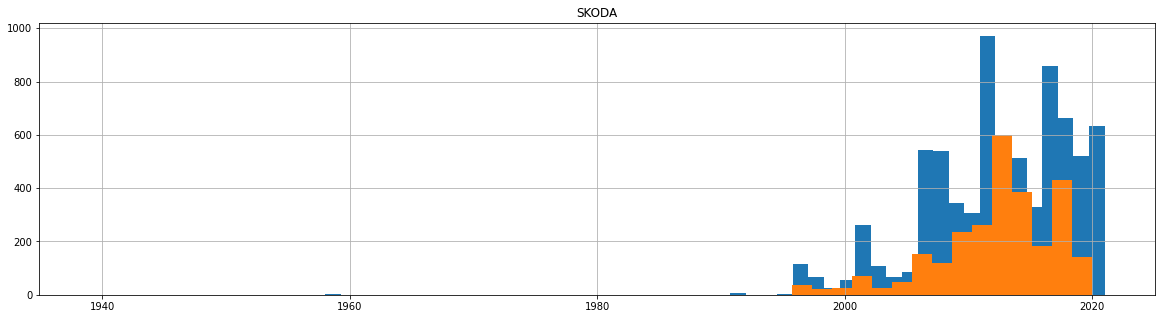

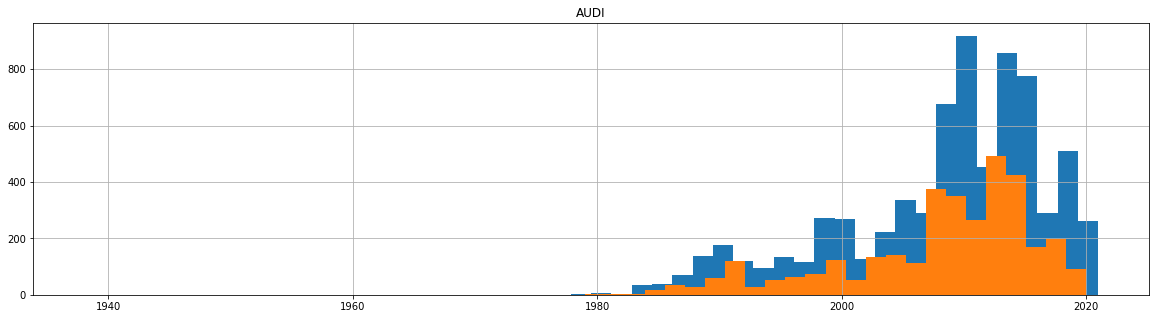

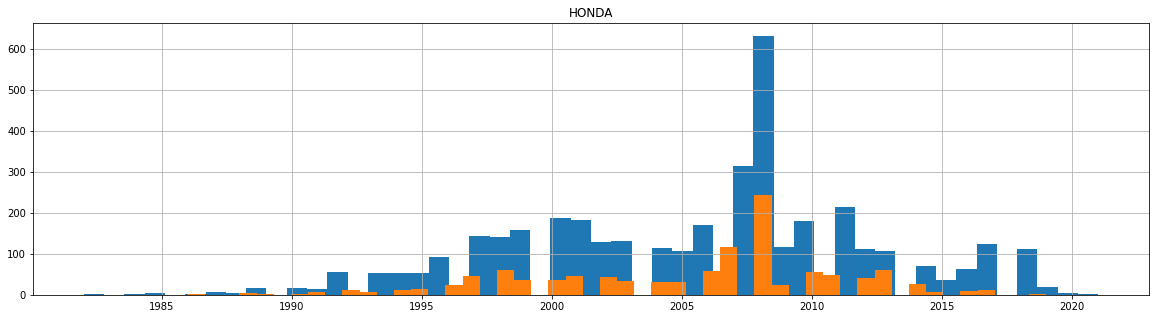

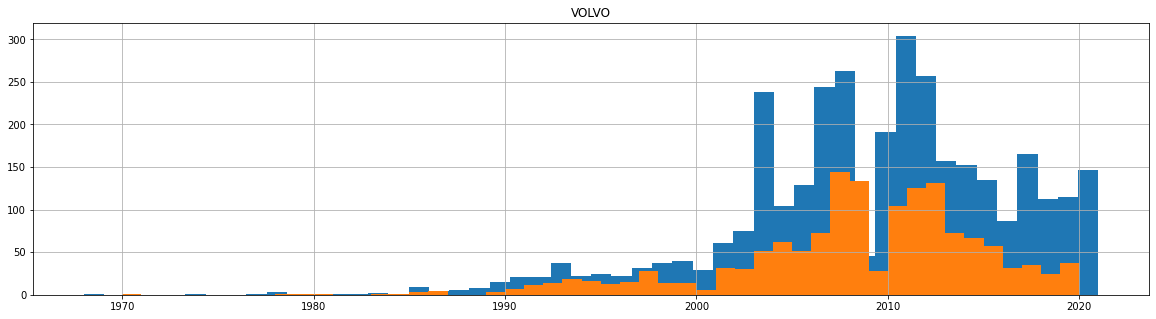

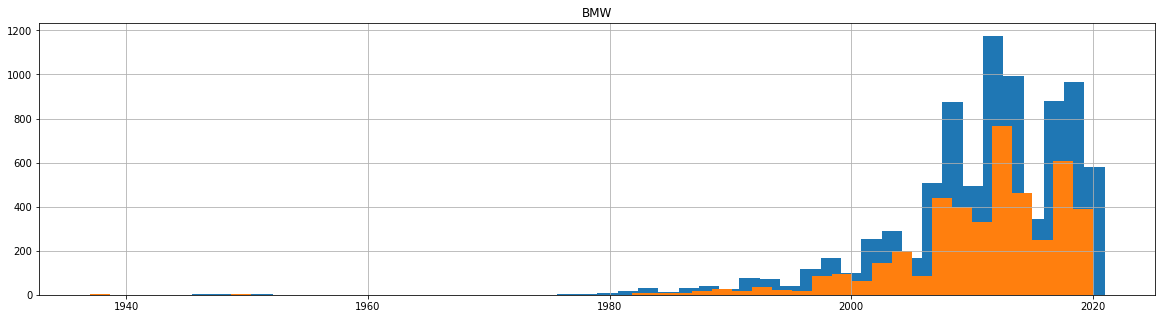

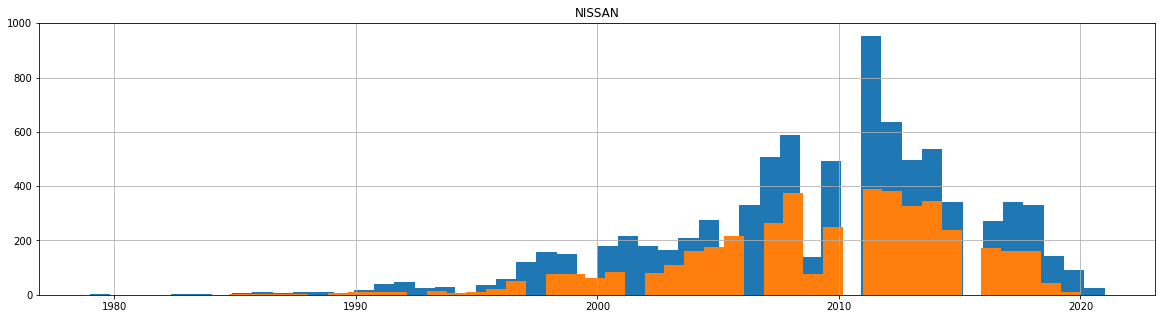

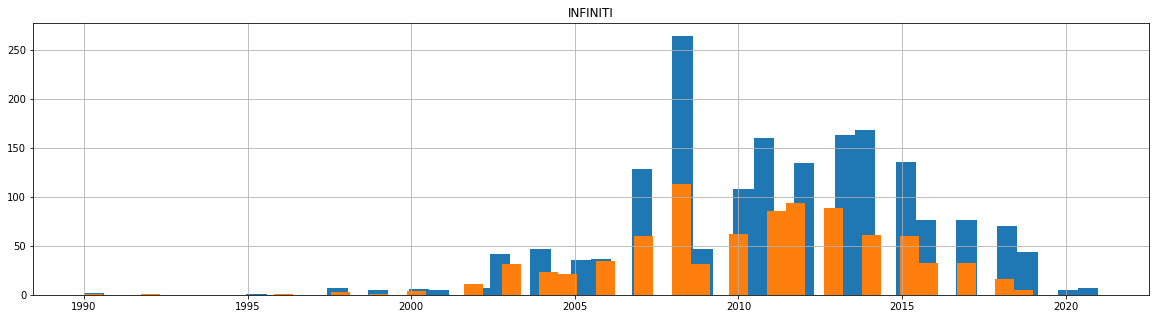

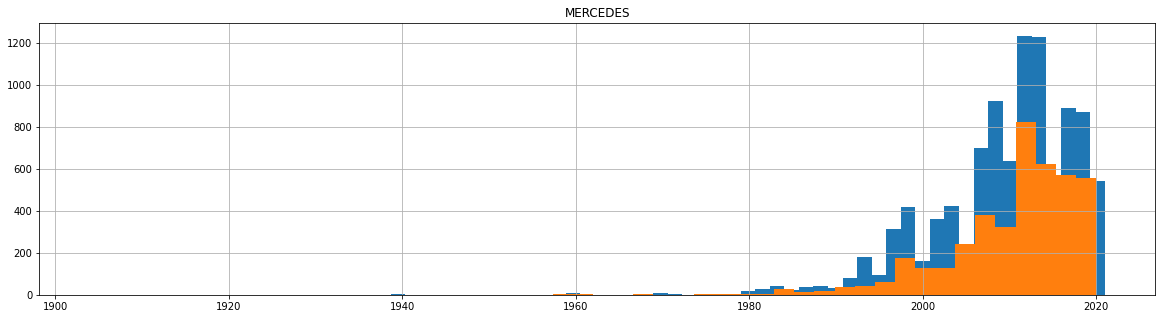

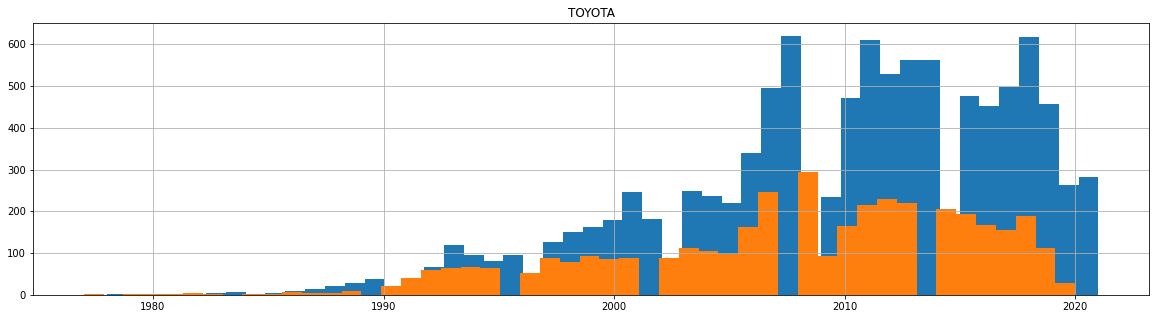

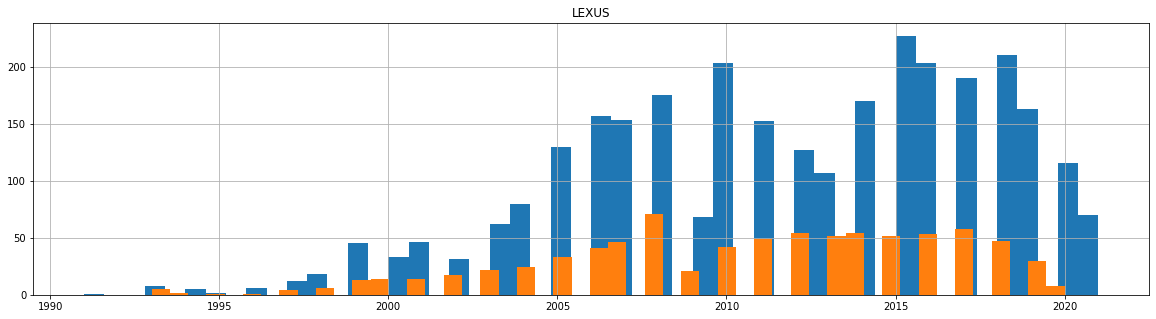

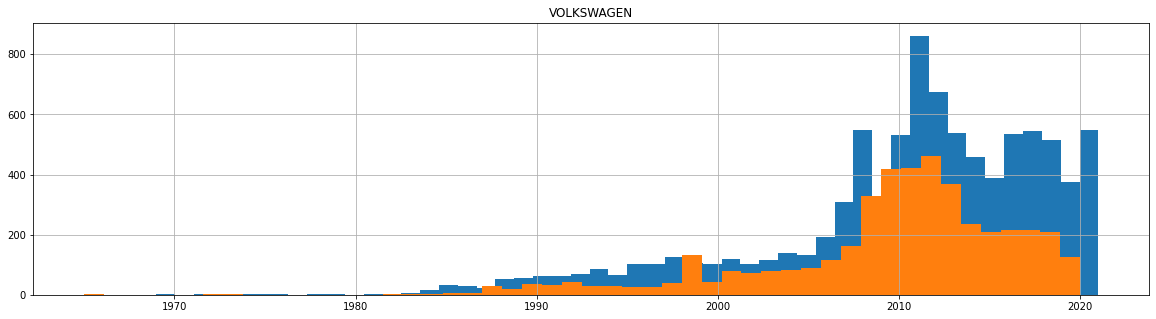

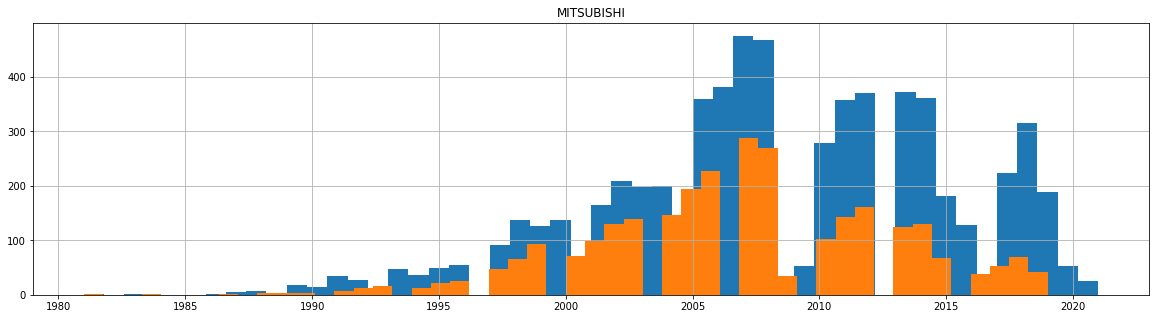

In [18]:
#посмотрим на структурное покрытие тестовых данных собранными данными в разрезе годов и брендов
#данные более менее похожи по структуре в тестовом сете
cols = data.brand.unique()

for col in cols:
    plt.figure(figsize=(20, 5))
    plt.title(col)
    df_train[df_train.brand == col].year.hist(bins=50), df_test[df_test.brand == col].year.hist(bins=50)

In [19]:
data.drop('customs', axis=1, inplace=True) #удалим неинформативный признак

In [20]:
#в тестовом сете не было колонки tax, мы ее создали и заполнили предварительно нулями
#заполним теперь ее значениями, спрогнозированными с помощью алгоритма KNeighbors
#для прогнозирования tax возьмем следующие признаки:['mileage', 'year', 'engineDisplacement', 'enginePower']

data_tax = data[data['tax'] !=0][['mileage', 'year', 'engineDisplacement', 'enginePower']]#тренировочный сет

y_tax = data[data['tax'] !=0]['tax']#таргет для тренировки

data_test_tax = data[data['tax'] ==0][['mileage', 'year', 'engineDisplacement', 'enginePower']]#сет для прогнозирования налога

clusterer = KNeighborsRegressor(n_neighbors = 7, weights='distance')
clusterer.fit(data_tax,y_tax) #создаем экземпляр модели с 11-ю соседями

y_tax_pred = clusterer.predict(data_test_tax)# делаем предсказание налога
y_tax_pred_df = pd.DataFrame(data=y_tax_pred, columns=['tax_new']) #создаем даатфрейм с колонкой прогнозных значений

data.loc[(data['tax'] ==0), 'tax'] = y_tax_pred_df['tax_new'].values #меняем нули в колонке tax на прогнозные значения
data.sample(10)

,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,pts,year,model_name,engineDisplacement,enginePower,fuelType,sample
111404,седан,AUDI,143172,серый,5,13715.000000,роботизированная,полный,Левый,1,Оригинал,2012,A4,2.0,211,Бензин,1
29686,седан,BMW,364417,серебристый,0,9033.167930,автоматическая,задний,Левый,3,Оригинал,1998,5ER,2.5,170,бензин,0
91410,хэтчбек 5 дв.,SKODA,76000,красный,0,1211.000000,механическая,передний,Левый,1,Оригинал,2013,FABIA,1.2,70,Бензин,1
50225,седан,MERCEDES,300000,серебристый,0,13440.000000,автоматическая,задний,Левый,1,Оригинал,2000,S_KLASSE,3.2,224,Бензин,1
104327,седан,LEXUS,51739,серый,0,10000.000000,автоматическая,передний,Левый,1,Оригинал,2018,ES,2.5,200,Бензин,1
37959,седан,BMW,16672,синий,20,9200.000000,автоматическая,полный,Левый,1,Оригинал,2020,3ER,2.0,184,Бензин,1
11544,внедорожник 5 дв.,NISSAN,131667,серебристый,0,3275.243059,вариатор,передний,Левый,2,Оригинал,2013,QASHQAI,1.6,117,бензин,0
90084,седан,TOYOTA,270000,белый,0,7600.000000,автоматическая,передний,Левый,1,Оригинал,2004,CAMRY,2.4,152,Бензин,1
3568,седан,AUDI,65000,чёрный,0,8827.957325,роботизированная,передний,Левый,1,Оригинал,2016,A6,2.0,190,дизель,0
61189,лифтбек,SKODA,66000,белый,0,3125.000000,роботизированная,передний,Левый,1,Оригинал,2019,RAPID,1.4,125,Бензин,1


Text(0.5, 1.0, 'year')

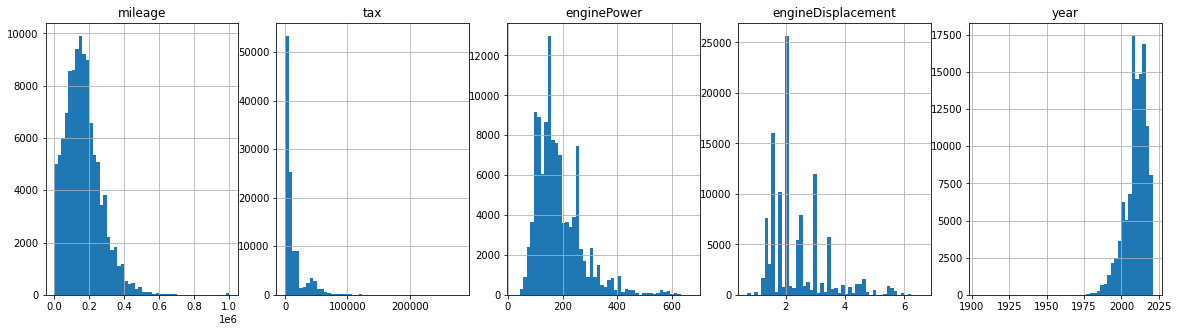

In [21]:
# посмотрим на распределение признаков и наличие выбросов
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
data.mileage.hist(bins=50)
plt.title('mileage')

plt.subplot(1, 5, 2)
data.tax.hist(bins=50)
plt.title('tax')

plt.subplot(1, 5, 3)
data.enginePower.hist(bins=50)
plt.title('enginePower')

plt.subplot(1, 5, 4)
data.engineDisplacement.hist(bins=50)
plt.title('engineDisplacement')

plt.subplot(1, 5, 5)
data.year.hist(bins=50)
plt.title('year')

In [22]:
#Разобьем признаки на группы:
nums = ['mileage', 'year', 'engineDisplacement', 'enginePower', 'tax'] #численные
ords = ['complectation', 'owners', 'brand', 'transmission', 'fuelType']#ориднальные
cats = ['bodytype', 'color', 'drive', 'wheel', 'pts']#категориальные

<AxesSubplot:>

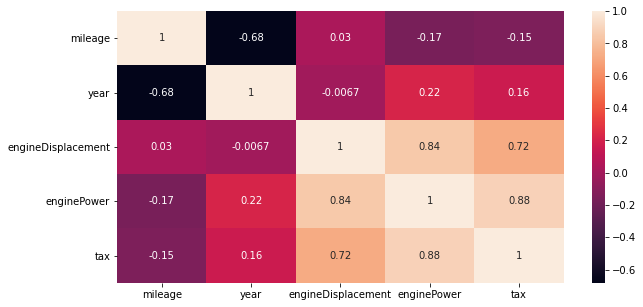

In [23]:
plt.figure(figsize=(10, 5))
sns.heatmap(data=data[nums].corr(), annot=True)
#посмотрим на корреляцию численных признаков

Text(0.5, 1.0, 'engine_new')

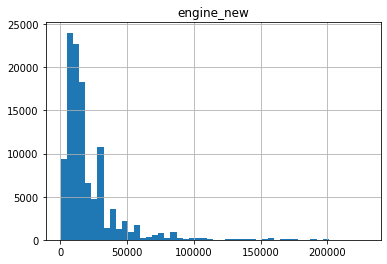

In [24]:
#engineDisplacement и enginePower сильно коррелируют
#удалять один из них не будем, а сделаем из них новый признак с помощью выделения главной компоненты
corr_matrix = data[['engineDisplacement','enginePower']].corr()
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)#найдем собственные векторы и значения матрицы корреляций признаков

index = np.argmax(eigenvalues)
eigenvectors.T[index]#выберем собственный вектор с максимальным собственным значением

a1 = eigenvectors.T[index][0]#первая координата собственного вектора
a2 = eigenvectors.T[index][1]#первая координата собственного вектора

data['engine_new'] = (a1*data['engineDisplacement']+a2*data['enginePower'])**2 #новый признак сделаем нелинейным к таргету, возведя его в квадрат
#так как цена, скорее всего ускоряется при росте мощности авто (премия за люксовость)
data.engine_new.hist(bins=50)
plt.title('engine_new')

In [25]:
#остальные численные признаки и complectation сузим до диапазонов, более близких к диапазонам ориднальных признаков
data['mileage'] = data[:]['mileage'].apply(lambda x: np.log(x))
data['tax'] = data[:]['tax'].apply(lambda x: np.log(x))
data['year'] = data[:]['year'].apply(lambda x: np.sqrt(x))
data['engineDisplacement'] = data[:]['engineDisplacement'].apply(lambda x: np.sqrt(x))
data['enginePower'] = data[:]['enginePower'].apply(lambda x: np.log(x))
data['engine_new'] = data[:]['engine_new'].apply(lambda x: np.log(x))
data['complectation'] = data[:]['complectation'].apply(lambda x: np.sqrt(x))

In [26]:
#колонку color преобразуем в ординальный признак с порядковой нумерацией
#сортированной по средней цене цвета авто
cols = list(train_test.groupby('color').price.mean().sort_values(ascending=False).index)

def colors_to_numbers(colors):
    if colors in cols:
        return cols.index(colors)
    else:
        return len(cols)+1

data['color'] = data[:]['color'].apply(colors_to_numbers)

In [27]:
#колонку bodytype также преобразуем в ординальный признак с порядковой нумерацией
#сортированной по средней цене типа кузова авто
bodies = list(train_test.groupby('bodytype').price.mean().sort_values(ascending=False).index)

def bodies_to_numbers(bodytype):
    if bodytype in bodies:
        return bodies.index(bodytype)
    else:
        return len(bodies)+1

data['bodytype'] = data[:]['bodytype'].apply(bodies_to_numbers)

In [28]:
#колонку brand также преобразуем в ординальный признак с порядковой нумерацией
#сортированной по средней цене брэнда авто
brands = list(train_test.groupby('brand').price.mean().sort_values(ascending=False).index)

def brands_to_numbers(brand):
    if brand in brands:
        return brands.index(brand)
    else:
        return len(brands)+1

data['brand'] = data[:]['brand'].apply(brands_to_numbers)

In [29]:
#для остальных ориднальгых признаков применим LabelEncoder
labelencoder = LabelEncoder()

data['transmission'] = labelencoder.fit_transform(data['transmission'])
data['fuelType'] = data.loc[:]['fuelType'].apply(lambda x: x.lower().strip())
data['fuelType'] = labelencoder.fit_transform(data['fuelType'])
data['model_name'] = labelencoder.fit_transform(data['model_name'])

data.sample(5)

,bodytype,brand,mileage,color,complectation,tax,transmission,drive,wheel,owners,pts,year,model_name,engineDisplacement,enginePower,fuelType,sample,engine_new
21747,6,4,11.643954,2,0.0,8.473157,1,передний,Правый,2,Оригинал,44.855323,648,1.341641,4.969813,0,0,9.271324
52961,5,1,10.480045,2,0.0,10.818778,0,полный,Левый,1,Оригинал,44.877611,385,1.732051,5.808142,0,1,10.941075
194,12,8,10.839581,2,0.0,8.933818,3,передний,Левый,1,Оригинал,44.899889,565,1.341641,5.192957,0,0,9.712667
45228,20,11,11.884489,2,0.0,6.926577,1,передний,Правый,1,Оригинал,44.833024,171,1.224745,4.718499,4,1,8.770458
4836,14,5,12.931203,4,0.0,8.781136,0,полный,Левый,3,Дубликат,44.743715,68,1.643168,5.521461,0,0,10.371259


In [30]:
#из трех признаков сделаем бинарные признаки
data = pd.get_dummies(data, columns = ['drive', 'wheel', 'pts'])

In [31]:
#из сильно коррелирующих признаков сделаем еще два новых ниленейных признака
data['mileage_year'] = data.loc[:]['mileage']*data.loc[:]['year']
data['eDispl_tax'] = data.loc[:]['engineDisplacement']*data.loc[:]['tax']

#наименований моделей очень много, приведем численную нумерацию моделей в более узкий диапазон
#data['model_name'] = data[:]['model_name'].apply(lambda x: int(np.log(x+1)))
data.sample(5)

,bodytype,brand,mileage,color,complectation,tax,transmission,owners,year,model_name,engineDisplacement,enginePower,fuelType,sample,engine_new,drive_задний,drive_передний,drive_полный,wheel_Левый,wheel_Правый,pts_Дубликат,pts_Оригинал,pts_ПТСДубликат,pts_ПТСОригинал,mileage_year,eDispl_tax
9233,5,2,10.858999,0,7.745967,11.182261,0,2,44.899889,656,1.732051,5.746203,6,0,10.818337,0,0,1,1,0,0,1,0,0,487.567846,19.368245
70892,5,7,12.345835,5,0.000000,7.293018,2,1,44.620623,271,1.341641,4.584967,0,1,8.513189,0,0,1,1,0,0,1,0,0,550.878831,9.784610
26119,5,7,11.589887,5,0.000000,8.942461,0,1,44.855323,580,1.414214,5.135798,0,0,9.601842,0,0,1,1,0,0,1,0,0,519.868103,12.646550
47296,5,0,10.591622,4,2.000000,10.315332,0,1,44.933284,286,2.144761,5.690359,0,1,10.718414,0,0,1,1,0,0,1,0,0,475.916367,22.123923
90000,11,4,11.373663,2,2.645751,9.005160,0,1,44.911023,116,1.581139,5.198497,0,1,9.731282,0,1,0,1,0,0,1,0,0,510.802860,14.238407


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112894 entries, 0 to 112893
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   bodytype            112894 non-null  int64  
 1   brand               112894 non-null  int64  
 2   mileage             112894 non-null  float64
 3   color               112894 non-null  int64  
 4   complectation       112894 non-null  float64
 5   tax                 112894 non-null  float64
 6   transmission        112894 non-null  int32  
 7   owners              112894 non-null  int64  
 8   year                112894 non-null  float64
 9   model_name          112894 non-null  int32  
 10  engineDisplacement  112894 non-null  float64
 11  enginePower         112894 non-null  float64
 12  fuelType            112894 non-null  int32  
 13  sample              112894 non-null  int64  
 14  engine_new          112894 non-null  float64
 15  drive_задний        112894 non-nul

[Вверх к содержанию](#Содержание)

# **4. Моделирование**

## ``4.1 Наивное моделирование``

```
В этом разделе построим модель, основанную на линейной регрессии. Посмотрим какие оценки дает линейная регрессия.
Также попробуем применть штрафные коэффициенты к регрессии и посмотрим, улучшит ли это наш прогноз.
```

In [33]:
#создадим функцию для оценки MAPE
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#создадим оценщика для кросс валидации и learning curve
score = make_scorer(MAPE)

RANDOM_SEED = 42

In [34]:
X = data.query('sample == 1').drop(['sample','tax'], axis=1) #отделим тренинговый сет
X_sub = data.query('sample == 0').drop(['sample','tax'], axis=1) #отделим тестовый для submission сет данных

In [35]:
#сделаем контроль размерности сетов
X.shape, X_sub.shape, y.shape

((78208, 24), (34686, 24), (78208,))

In [36]:
#разобьем данные на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [37]:
#сделаем прогноз и оценку точности прогноза с помощью простой линейной регрессии
regressor_LR = LinearRegression()
model_LR = regressor_LR.fit(X_train, np.log(y_train))
y_pred = np.exp(model_LR.predict(X_test))

MAPE(y_test, y_pred)
#оценка на тестовом сете в kagle.com дала результат 22,07%
#что лучше, чем прогноз по тренинговому сету, но не является хорошей точностью

24.025810559600835

In [41]:
#проверим есть ли эффект от применения штрафа в регрессии
regressor_ridge = Ridge()
alpha = np.linspace(0.1, 1, 20, dtype=float)

hyperparameters = dict(alpha=alpha)
rsearch = GridSearchCV(regressor_ridge,
                       hyperparameters,
                       cv=5,
                       verbose=0)

model_ridge = rsearch.fit(X, np.log(y))
print('alpha =', model_ridge.best_estimator_.get_params()['alpha'])
#оценка на тестовом сете в kagle.com дала результат 22,07%, что так же, как прогноз без штрафа
#также видно, что выбор регрессии со штрафом стремится к минимальной альфе, то есть к чистой линейной регрессии

alpha = 0.1


In [42]:
regressor_lasso = Lasso()
alpha = np.linspace(0.1, 1, 20, dtype=float)

hyperparameters = dict(alpha=alpha)
rsearch = GridSearchCV(regressor_ridge,
                       hyperparameters,
                       cv=5,
                       verbose=0)

model_lasso = rsearch.fit(X, np.log(y))
print('alpha =', model_lasso.best_estimator_.get_params()['alpha'])
#с линейным штрафом получили аналогичный результат

alpha = 0.1


```
наилучшим образом себя показала линейная регрессия без штрафа
попробуем в дальнейшем использовать ее в стекинге моделей
```

[Вверх к содержанию](#Содержание)

## ``4.2 Ранжирование дефолтных моделей``

In [44]:
# Создаем конвейер задач, в который включим несколько моделей с дефолтными значениями
#по итогам моделирование ранжируем дефолтные модели по результативности
pipe = Pipeline([('regressor', RandomForestRegressor(random_state=RANDOM_SEED))])

# Создадим словарь вариантов алгоритмов
search_space = [{'regressor': [RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)]},
                {'regressor': [LinearRegression()]},
                {'regressor': [ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_SEED)]},
                {'regressor': [AdaBoostRegressor(random_state=RANDOM_SEED)]},
                {'regressor': [GradientBoostingRegressor(random_state=RANDOM_SEED)]},
                {'regressor': [KNeighborsRegressor()]},
                {'regressor': [BaggingRegressor(n_jobs=-1, random_state=RANDOM_SEED)]},
                {'regressor': [DecisionTreeRegressor()]}]

# Создадим экземпляр решетечного поиска
gridsearch = GridSearchCV(pipe, search_space, scoring=score, cv=5, verbose=0)

# выполним поиск наилучшей модели в заданном диапазоне гиперпараметров с логарифмом целевых значений
best_default_model = gridsearch.fit(X, np.log(y))

In [45]:
best_model_results = pd.DataFrame(data=best_default_model.cv_results_)
best_model_results[['param_regressor','mean_test_score']]
#наилучшим алгоритмом с дефолтными значениями оказался ExtraTreesRegressor
#рейтинг алогоритмов ниже в таблице будет использован далее для выбора моделей в стекинге

,param_regressor,mean_test_score
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",1.081079
1,LinearRegression(),1.807133
2,"ExtraTreesRegressor(n_jobs=-1, random_state=42)",1.053616
3,AdaBoostRegressor(random_state=42),2.373723
4,GradientBoostingRegressor(random_state=42),1.430435
5,KNeighborsRegressor(),2.553820
6,"BaggingRegressor(n_jobs=-1, random_state=42)",1.138428
7,DecisionTreeRegressor(),1.432122


In [46]:
#ExtraTreesRegressor оказалось лучшей моделью
#сделаем прогноз на лучшей дефолтной модели
regressor_etree = ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_SEED)
model_default_extree = regressor_etree.fit(X_train, np.log(y_train))
y_pred = np.exp(model_default_extree.predict(X_test))

MAPE(y_test, y_pred)
#мы получили значительное улучшение в точности модели относительно линейных регрессий
#оценка на тестовом сете в kagle.com дала точность прогноза в размере 15,33%

13.418752153678145

In [48]:
#дополнительно в этом разделе посмотрим динамику обучающей кривой (роста точности моделирования
#в зависимости от количества данных)
#будем смотреть стоит ли еще добрать данные для повышения точности
kf = KFold(n_splits = 3, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(regressor_etree, X, y,
                               cv=kf,
                               scoring=score,
                               n_jobs=-1,
                               train_sizes=np.linspace(0.01, 1.0,7))

In [49]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

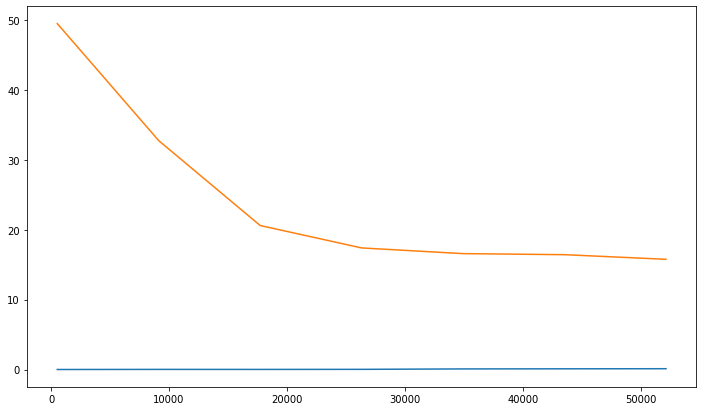

In [50]:
# значительного улучшения точности уже не наблюдается, поэтому добирать данные больше не будем
plt.figure(figsize=(12, 7))

plt.plot(train_sizes, train_mean)
plt.plot(train_sizes, test_mean)
plt.show()

[Вверх к содержанию](#Содержание)

## `4.3 Поиск лучших гиперпараметров`

 ```
 Попробуем найти лучшие гиперпараметры для наилучшей дефолтной модели ExtraTreesRegressor
  ```

In [66]:
regressor_etree = ExtraTreesRegressor(random_state=RANDOM_SEED,  n_jobs=-1)

max_features = np.linspace(1, 22, 5, dtype=int)
n_estimators = np.linspace(50, 500, 5, dtype=int)

hyperparameters = dict(n_estimators=n_estimators)
rsearch = GridSearchCV(regressor_etree,
                       hyperparameters,
                       cv=5,
                       verbose=0)

best_model_etree = rsearch.fit(X, np.log(y))
best_model_etree.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [51]:
# в Gridsearch отдельно пришлось искать лучшие n_estimators и max_features, долго считает
# в итоге лучшими параметрами стали 16 фичей и 500 деревьев
#сделаем предсказание модели ExtraTreesRegressor с такими гиперпараметрами
regressor_etree = ExtraTreesRegressor(random_state=RANDOM_SEED,
                                      n_estimators = 500,
                                      max_features = 16,
                                      n_jobs=-1)
best_model_extree = regressor_etree.fit(X_train, np.log(y_train))
y_pred = np.exp(best_model_extree.predict(X_test))

MAPE(y_test, y_pred)
#получили улучшение относительно дефолтной модели
#точность прогноза на тестовом сете в kagle.com также улучшилась и стала 15,06%

13.249838398648958

                    importance
feature                       
year                     0.377
drive_полный             0.143
mileage                  0.066
mileage_year             0.066
enginePower              0.063
engine_new               0.055
drive_передний           0.046
bodytype                 0.030
brand                    0.026
eDispl_tax               0.021
engineDisplacement       0.019
transmission             0.017
fuelType                 0.014
model_name               0.013
wheel_Левый              0.009
color                    0.009
wheel_Правый             0.007
pts_Дубликат             0.007
drive_задний             0.005
complectation            0.004
owners                   0.002
pts_Оригинал             0.002
pts_ПТСДубликат          0.000
pts_ПТСОригинал          0.000


<AxesSubplot:ylabel='feature'>

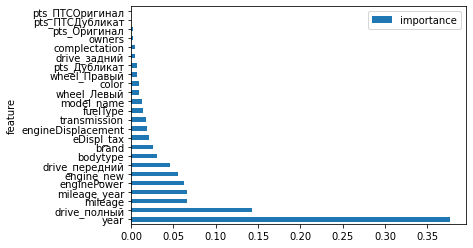

In [53]:
#посмотрим какие признаки используются чаще всего в деревьях
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(regressor_etree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print (importances)
importances.plot.barh()

```
 Для стекинга лучше брать разные по природе модели. Возьмем три слабые: Ridge,Kneighbors,DecisionTree и пару сильных GBRegressor и ExtraTreesRegressor. Для ExtraTreesRegressor гиперпараметры подобрали. Теперь подберем их для Kneighbors,DecisionTree и GBRegressor. Потом эти модели с такими параметрами используем в стекинге.
  ```

In [73]:
#прогноим гиперпараметры для одного дерева
regressor_dtree = DecisionTreeRegressor(random_state=RANDOM_SEED)

max_features = np.linspace(1, 22, 9, dtype=int)
max_depth = np.linspace(3, 700, 9, dtype=int)

hyperparameters = dict(max_features=max_features,
                      max_depth=max_depth)
rsearch = GridSearchCV(regressor_dtree,
                       hyperparameters,
                       cv=5,
                       verbose=0)

best_model_dtree = rsearch.fit(X, np.log(y))
best_model_dtree.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 90,
 'max_features': 19,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [74]:
# сделаем предсказание по лучшей выбранной модели дерева решений
y_pred = np.exp(best_model_dtree.predict(X_test))

MAPE(y_test, y_pred)

0.17238685972460932

In [80]:
#прогноим гиперпараметры для соседей
regressor_neighbor = KNeighborsRegressor()
n_neighbors = np.linspace(3, 9, 3, dtype=int)

hyperparameters = dict(n_neighbors=n_neighbors)
rsearch = GridSearchCV(regressor_neighbor,
                       hyperparameters,
                       cv=5,
                       verbose=0)

best_model_neighbor = rsearch.fit(X, np.log(y))
best_model_neighbor.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'uniform'}

In [81]:
# сделаем предсказание по лучшей выбранной модели K соседей
y_pred = np.exp(best_model_neighbor.predict(X_test))

MAPE(y_test, y_pred)

28.054417621406202

In [54]:
#прогоним гиперпараметры для грпдиентного спуска
regressor_gbt = GradientBoostingRegressor(random_state=RANDOM_SEED)
n_estimators = np.linspace(200, 500, 3, dtype=int)
learning_rate = np.linspace(0.2, 0.6, 4, dtype=float)

hyperparameters = dict(n_estimators=n_estimators)
rsearch = GridSearchCV(regressor_gbt,
                       hyperparameters,
                       cv=5,
                       verbose=0)

best_model_gbt = rsearch.fit(X_train, np.log(y_train))
best_model_gbt.best_estimator_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [57]:
# в Gridsearch отдельно пришлось искать лучшие n_estimators и learning_rate, долго считает
# в итоге лучшими параметрами стали 0.47 скорость обучения и 500 деревьев
#сделаем предсказание модели  GradientBoostingRegressor с такими гиперпараметрами
regressor_gbt =  GradientBoostingRegressor(random_state=RANDOM_SEED,
                                      n_estimators = 500,
                                      learning_rate = 0.47)
best_model_gbt = regressor_gbt.fit(X_train, np.log(y_train))
y_pred = np.exp(best_model_gbt.predict(X_test))

MAPE(y_test, y_pred)

14.872304687947135

[Вверх к содержанию](#Содержание)

## `4.4 Стекинг алгоритмов`

```
 В этом разделе попробуем улучшить точность прогноза с помощью стекинга (сочетания) различных по природе моделей. Также попробуем из meta features сделать нелинейные metafeatures. Прогнозы моделей делаются на 5-ти фолдах, и для каждого фолда подбираются немного разные коэффициенты (параметры) моделей. По этой причине meta features имеют небольшой разброс относительно друг друга на разных кусках(фолдах) данных, попробуем этот разброс сузить, применив взаимное перемножение metafeatures.
  ```

In [58]:
# функция прогнозирования metafetures для отдельной модели
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    return X_meta_train, X_meta_test

In [59]:
# функция сбора metafeatures в один массив
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):

    features = [compute_meta_feature(clf, X_train, X_test, y_train, cv) for clf in tqdm(classifiers)]
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    
    return stacked_features_train, stacked_features_test

In [89]:
#сделаем прогноз сначала на дефолтных моделях
# потом сделаем прогноз на лучших моделях (кроме Ridge)
cv = KFold(n_splits=5, shuffle=True)

stacked_features_train, stacked_features_test = generate_meta_features([
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=6),
    GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.47, random_state=RANDOM_SEED),
    DecisionTreeRegressor(max_features = 19, max_depth = 90, random_state=RANDOM_SEED),
    ExtraTreesRegressor(n_estimators = 500, max_features = 16, random_state=RANDOM_SEED, n_jobs=-1)],
    X.values,
    X_sub.values,
    np.log(y.values),
    cv)

  0%|          | 0/5 [00:00<?, ?it/s]

In [90]:
#посмотрим размер массивов
#мы получили 5 metafeatures, как и должно быть
stacked_features_train.shape, stacked_features_test.shape

((78208, 5), (34686, 5))

In [91]:
#сделаем прогноз на 5 metafeatures, в качестве модели выберем линейную регрессию
regressor_stacked = LinearRegression()
regressor_stacked.fit(stacked_features_train, np.log(y.values))
y_pred = np.exp(regressor_stacked.predict(stacked_features_test))

#на дефолтных моделях получили незначительное улучшение, точность оказалась 15,015%
#а вот на моделях с лучшими выбранными гиперпараметрами улучшение оказалось заметнее,
#точность выросла до 14,55%

In [93]:
#из metafeatures составим новые нелинейные metafetures
poly = PolynomialFeatures(degree=2,
                          interaction_only=True,
                          include_bias=False)
poly_train = poly.fit_transform(stacked_features_train)
poly_test = poly.fit_transform(stacked_features_test)

In [94]:
#количество мета признаков выросло до 15
poly_train.shape, poly_test.shape

((78208, 15), (34686, 15))

In [95]:
#сделаем прогноз по дополненным мета признакам
regressor_stacked = LinearRegression()
regressor_stacked.fit(poly_train, np.log(y.values))
y_pred = np.exp(regressor_stacked.predict(poly_test))

#метод дал улучшение точности, но не сильное - до 14,53%

In [79]:
#сделаем прогноз на сиключительно нелинейных мета признаках
regressor_stacked = LinearRegression()
regressor_stacked.fit(poly_train[:,5:], np.log(y.values))
y_pred = np.exp(regressor_stacked.predict(poly_test[:,5:]))

#метод дал ухудшение точности до 14,72%

## `4.5 Формирование файла Submission`

In [99]:
#predict_submission = np.exp(best_model_extree.predict(X_sub))
predict_submission = y_pred
sample_submission['price'] = predict_submission
sample_submission.to_csv(DIR + 'submission.csv', index=False)

submission = pd.read_csv(DIR + 'submission.csv')
submission.head(10)

,sell_id,price
0,1100575026,6.958578e+05
1,1100549428,1.010880e+06
2,1100658222,8.887171e+05
3,1100937408,8.267429e+05
4,1101037972,8.349998e+05
5,1100912634,7.387870e+05
6,1101228730,6.584602e+05
7,1100165896,4.062655e+05
8,1100768262,1.906940e+06
9,1101218501,7.438704e+05


[Вверх к содержанию](#Содержание)